## Preprocessing

In [252]:
!pip install mne
!pip install pyentrp
! pip install hurst

In [253]:
# Helper Functions

# Create trials from data

def create_trials(data ):
  boundary_frames = []
  for i in range(0 , len(data[61, :])):
    if (data[61 , i]!=0) and ((data[61, i-1] == 0) or (data[61,i+1]==0)):
      boundary_frames.append(i)
  
  Ecog_data = []
  Ecog_label = []
  Fingers_data = []
  for i in range(0 , len(boundary_frames) , 2):

    
      Ecog_data.append(data[1:61 , boundary_frames[i]-1000:boundary_frames[i+1]+1001] [: , 0:4400])
      Fingers_data.append( data[62: , boundary_frames[i]-1000:boundary_frames[i+1]+1001] [: , 0:4400])
      Ecog_label.append(data[61 , boundary_frames[i] ])

  return np.stack(Ecog_data) , Ecog_label , np.stack(Fingers_data)
#np.vstack([data[1:61,:] ,data[62: , :]]


def compute_accuracy(X, y, model ,threshold = 0.5):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X )
 # if y_pred.dtype == 'float64':
  #  y_pred = (y_pred > threshold).astype('int32')
   # accuracy = (y ==  y_pred).mean()
  #else:

  accuracy = (y == y_pred).mean()

  return accuracy , y_pred


def band_power(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp



In [254]:
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
import scipy.stats as stats
from scipy import signal

from pyentrp import entropy as ent

In [255]:
# Extracting data matrix
data  = io.loadmat('/content/drive/MyDrive/ecog/ECoG_Handpose.mat')['y']

**Paradigm description:** 90 trials of rock-paper-scissors gestures following a cue on a presentation screen.               
The gesture cue, a photograph of a rock, paper or scissors gesture, was presented for 2s, followed by a black screen for 2-3s.                
**Data matrix description:** [channel x time]  (67 * 507025)    
**CH1:** sample time       
**CH2-61:** ECoG (raw and DC-coupled; recorded from right sensorimotor cortex)       
**CH62:** paradigm info (0...relax, 1...fist movement, 2...peace movement, 3...open hand)       
**CH63:** data glove thumb    
**CH64:** data glove index   
**CH65:** data glove middle         
**CH66:** data glove ring   
**CH67:** data glove little  
**Sampling frequency:** 1200 Hz  




In [256]:
# Separate based on trials to create 90 epochs
ecog_data , ecog_label , fingers_data = create_trials(data)

In [270]:
# Creating MNE compatible Epoch objects

info = mne.create_info(ch_names = 60 , sfreq = 1200, ch_types = ['ecog']*60 , verbose=None)

#Creating events array : This is of shape(n_events, 3) where the first column is the index of the event, 
#the second column is the length of the event, and the third column is the event type 
#4400/1200  because the trials contain 4400 datapoints each and it is converted to seconds based on sampling frequency

events = np.stack([[i , 1 , int(ecog_label[i]) ] for i in range(0 , len(ecog_label))])
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )
tmin = -0.5
custom_epochs = mne.EpochsArray(ecog_data, info, events, tmin, event_id)

print(custom_epochs)

custom_epochs.set_eeg_reference()

# Filter the data : [50 to 300 Hz]
filtered = custom_epochs.copy().filter(50 , 300)
filtered = filtered.apply_baseline((-0.5 , 0))
filtered_df = filtered.to_data_frame()


Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
<EpochsArray |  90 events (all good), -0.5 - 3.16583 sec, baseline off, ~181.3 MB, data loaded,
 'fist_movement': 30
 'open_hand': 30
 'peace_movement': 30>
ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.
Setting up band-pass filter from 50 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 317 samples (0.264 sec)

Applying baseline correction (mode: mean)


Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


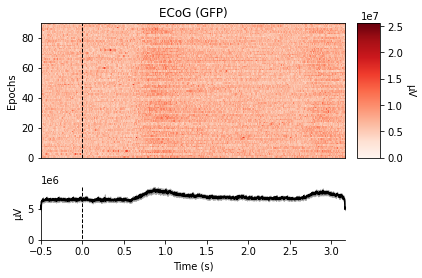

[<Figure size 432x288 with 3 Axes>]

In [271]:
filtered.plot_image()

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer , MinMaxScaler
from sklearn.linear_model import LogisticRegression ,  SGDClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



 Using MNE/sklearn

In [304]:
# Feature extractation for each epoch

# Declare feature variables
mean = []
amplitude = []
kurt = []
skew = []
std = []
rms = []
alpha = []
beta = []
gradient = []
theta = []
delta = []
gamma = []
rel_b_a = []
rel_b_t =[]
rel_b_d = []
rel_a_t = []




In [305]:
#For each epoch in the data compute the features

for i in filtered.get_data():
   rms.append(np.sqrt(np.mean(np.power(i, 2))))
   mean.append(np.mean(i))
   kurt.append(np.mean(stats.kurtosis(i , axis = None)))
   skew.append(np.mean(stats.skew(i , axis = None)))
   std.append(np.std(i))
   gradient.append(np.mean(np.gradient(i)))
   
   alpha.append(band_power(np.mean(i , axis = 0), 1200 , [8 , 12] , 'multitaper'))
   beta.append(band_power(np.mean(i , axis = 0), 1200 , [12,30] , 'multitaper'))
   theta.append(band_power(np.mean(i , axis = 0), 1200 , [4,8] , 'multitaper'))
   delta.append(band_power(np.mean(i , axis = 0), 1200 , [0.5,4] , 'multitaper'))
   gamma.append(band_power(np.mean(i , axis = 0), 1200 , [31 , 100] , 'multitaper'))
rel_b_a =[i / j for i, j in zip(beta , alpha)]
rel_b_t =[i / j for i, j in zip(beta , theta)]
rel_b_d =[i / j for i, j in zip(beta , delta)]
rel_a_t=[i / j for i, j in zip(alpha , theta)]

In [306]:
#DataFrame of features from the Ecog

Ecog_feature_df = pd.DataFrame([mean , kurt , skew, std, rms, gradient, alpha, beta, theta, delta, gamma , rel_b_a, 
                    rel_b_t, rel_b_d , rel_a_t]).transpose()

In [307]:
# Fingers features

f_mean = np.mean(fingers_data, axis = 2)
f_std  = np.std(fingers_data, axis = 2)
f_skew = stats.skew(fingers_data, axis = 2)
f_kurt = stats.kurtosis(fingers_data, axis = 2)

#Dataframe of feature from the Ecog
Finger_features_df = pd.DataFrame(np.hstack(( f_mean , f_std , f_skew, f_kurt)))

In [308]:
 # Combining both Ecog and finger dataframes
complete_feature_matrix = pd.concat([Ecog_feature_df, Finger_features_df], axis=1)

In [265]:
column_names = [ 'Ecog_mean' , 'Ecog_kurt' , 'Ecog_skew', 'Ecog_std', 'Ecog_rms', 'Ecog_gradient', 'Ecog_alpha', 'Ecog_beta', 'Ecog_theta', 'Ecog_delta', 'Ecog_gamma' , 'rel_beta_alpha', 
                    'rel_beta_theta', 'rel_beta_delta' , 'rel_alpha_theta' , 'thumb_mean' , 'index_mean' , 'middle_mean' , ' ring_mean' , ' little_mean', 'thumb_std' , 'index_std' , 'middle_std' , ' ring_std' , ' little_std' , 
                'thumb_skew' , 'index_skew' , 'middle_skew' , ' ring_skew' , ' little_skew' , 'thumb_kurt' , 'index_kurt' , 'middle_kurt' , ' ring_kurt' , ' little_kurt' ]

## Training and Test data split

In [317]:
#Splitting into X_train and Y train
x_train, x_test, y_train, y_test = train_test_split(Ecog_feature_df, np.array(ecog_label), test_size = 0.15, shuffle=True, random_state=33)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.15, shuffle=True, random_state=33)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.3, shuffle=True, random_state=33)
x_train, x_test, y_train, y_test = train_test_split(complete_feature_matrix, np.array(ecog_label), test_size = 0.5, shuffle=True, random_state=333)

In [336]:
x_train, x_test, y_train, y_test = train_test_split(Ecog_feature_df, np.array(ecog_label), test_size = 0.15, random_state= 0)

In [338]:
 from sklearn.ensemble import RandomForestClassifier

 clf = RandomForestClassifier(n_estimators=10 , random_state = 0)
 clf = clf.fit(x_train, y_train)

#Logistic Regression

In [360]:
logreg = LogisticRegression()
logreg.fit(x_train , y_train)
training_accuracy , _ = compute_accuracy(x_train , y_train , logreg)
print(f"Accuracy on the training data: {training_accuracy: .2%}")
pipe = make_pipeline(StandardScaler(), LogisticRegression(solver = 'saga' , max_iter = 20000 , multi_class = 'multinomial' , penalty = 'l1'))
pipe.fit(x_train, y_train) 

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=20000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [361]:
# testing the model
test_accuracy , prediction = compute_accuracy(x_test , y_test , pipe)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the  test data:  78.57%


In [227]:
print(list(zip(prediction , y_test)))

[(3.0, 3.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (3.0, 3.0), (2.0, 2.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (3.0, 3.0), (1.0, 1.0), (2.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (1.0, 1.0), (1.0, 1.0), (3.0, 3.0), (3.0, 3.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0)]


In [ ]:
pipe.predict_log_proba(x_test)

#SGD classifier

In [323]:
sgd_clf = SGDClassifier(random_state = 230, max_iter = 100000 , eta0 = 0.1)
sgd_clf.fit(x_train, y_train)
training_accuracy , _ = compute_accuracy(x_train , y_train , sgd_clf)
print(f"Accuracy on the training data: {training_accuracy: .2%}")

Accuracy on the training data:  42.11%


In [231]:
# testing the model
test_accuracy , _ = compute_accuracy(x_test , y_test , sgd_clf)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the  test data:  91.11%


In [332]:
from sklearn.svm import SVC

svc = SVC(kernel="poly", degree= 2,   random_state = 42)

svc.fit(x_train , y_train)

training_accuracy, _= compute_accuracy(x_train , y_train ,svc)
print(f"Accuracy on the training data: {training_accuracy: .2%}")
test_accuracy , _110 = compute_accuracy(x_test , y_test , svc)
print(f"Accuracy on the  test data: {test_accuracy: .2%}")

Accuracy on the training data:  58.02%
Accuracy on the  test data:  55.56%


## Plots

In [244]:
complete_feature_matrix.columns = [ 'Ecog_mean' , 'Ecog_kurt' , 'Ecog_skew', 'Ecog_std', 'Ecog_rms', 'Ecog_gradient', 'Ecog_alpha', 'Ecog_beta', 'Ecog_theta', 'Ecog_delta', 'Ecog_gamma' , 'rel_beta_alpha', 
                    'rel_beta_theta', 'rel_beta_delta' , 'rel_alpha_theta' , 'thumb_mean' , 'index_mean' , 'middle_mean' , ' ring_mean' , ' little_mean', 'thumb_std' , 'index_std' , 'middle_std' , ' ring_std' , ' little_std' , 
                'thumb_skew' , 'index_skew' , 'middle_skew' , ' ring_skew' , ' little_skew' , 'thumb_kurt' , 'index_kurt' , 'middle_kurt' , ' ring_kurt' , ' little_kurt' ]